In [356]:
# to get the generes and songs json files location
import os
import random
import json
import matplotlib.pyplot as plt
from statistics import mean

cwd = os.getcwd()
cwd += "/song_db"


def get_genere_dict(path):
    
    json_files = os.listdir(path)
    genere_dict = {}
    
    for file in json_files:
        file_path = f"{path}/{file}"
        genere = file.split(".")[0]
        with open(file_path) as fp:
            genere_dict[genere] = json.load(fp)
        
    return genere_dict

In [357]:
# get the generes dictionary and the list of geners
genere_dict = get_genere_dict(cwd)
generes = list(genere_dict.keys())
# select number of generes you want 
num_of_gens = 3
selected_generes = random.sample(generes, num_of_gens)
# get all songs form those generes
songs = {}

for genere in selected_generes:
    songs.update(genere_dict[genere])

print(f"The selected generes are {selected_generes}")

The selected generes are ['blues', 'black-metal', 'brazil']


In [358]:
# step 1 define constants and parameters

TOTAL_NUM_SONGS = len(songs)
NUM_SONGS = 20  # Number of songs of the playlist
POPULATION_SIZE = 100  # Number of candidate solutions in each generation
NUM_GENERATIONS = 300  # Number of generations
MUTATION_RATE = 0.2  # Probability of mutation

In [359]:
def calculate_fitness(solution, desired_values, songs, weights = {"energy_weight": 1.0, "valence_weight": 1.0, "popularity_weight": 1.0, "length_weight": 1.0}):
    total_diff = 0

    # Weights
    energy_weight = weights["energy_weight"]
    valence_weight = weights["valence_weight"]
    popularity_weight = weights["popularity_weight"]
    length_weight = weights["length_weight"]
    exceed_length_penalty = 20  # penalty if playlist length exceeds the desired length

    min_length = min([songs[song]['length'] for song in songs])
    max_length = max([songs[song]['length'] for song in songs])
    song_lengths = [songs[song]['length'] for song in solution]
    normalized_lengths = [(x - min_length) / (max_length - min_length) for x in song_lengths]
    normalized_desirelen = (desired_values["length"] - min_length) / (max_length - min_length)
    
    for song_id in solution:
        song = songs[song_id]
        
        # Normalized differences.
        energy_diff = abs((song['energy']/100) - (desired_values['energy']/100))
        valence_diff = abs((song['valence']/100) - (desired_values['valence']/100))
        popularity_diff = abs((song['pop']/100) - (desired_values['pop']/100))

        # Weighted sum of differences
        total_diff += (energy_weight * energy_diff) + (valence_weight * valence_diff) + (popularity_weight * popularity_diff)
    length_diff = abs(sum(normalized_lengths) - normalized_desirelen)

    # Apply penalty if total playlist length exceeds the desired length
    if (180-min_length)/(max_length-min_length) > length_diff:
        total_diff += exceed_length_penalty

    total_diff += length_weight * length_diff

    return total_diff


In [360]:
# step 3 get a initial population

def generate_individual(songs):
    
    song_indices = random.sample(range(TOTAL_NUM_SONGS), NUM_SONGS)
    return [list(songs.keys())[i] for i in song_indices]

population = [generate_individual(songs) for _ in range(POPULATION_SIZE)]
print(calculate_fitness(population[1], desired_values, songs))
# now it generates a population of POPULATION_SIZE (50) playlists each one with NUM_SONGS (20) number songs

23.878993939393936


In [361]:
# step 4 define genetic operators

# SELECTION
def selection(population, desired_values):
    fitness_scores = [calculate_fitness(individual, desired_values, songs) for individual in population]
    sorted_population = [x for _, x in sorted(zip(fitness_scores, population))]
    selected_population = sorted_population[:int(POPULATION_SIZE * 0.2)]  # Select top 20% fittest individuals
    return selected_population

# we end up with a population of 10 (20% POPULATION_SIZE)

In [362]:
# CROSSOVER
# CROSSOVER
def crossover(parent1, parent2):
    # select random crossover point
    # this point will depend on the shortest sequence to not get IndexError
    max_length = min(len(parent1), len(parent2))
    
    ## crossover_point = random.randint(1, NUM_SONGS - 1)
    crossover_point = random.randint(1, max_length - 1)
    
    # get two childs with the crossover of the parents
    
    ## child1, child2 = list(range(NUM_SONGS)), list(range(NUM_SONGS))
    child1, child2 = list(range(len(parent1))), list(range(len(parent2)))
    
    # we avoid duplicates with this for loop
    # we do crossover until crossover point
    for i in range(0, crossover_point):
        
        if parent1[i] not in parent2:
            child2[i] = parent1[i]
        else:
            child2[i] = parent2[i]

        if parent2[i] not in parent1:
            child1[i] = parent2[i]
        else:
            child1[i] = parent1[i]
            
    # from crossover point onward is the same
    for i in range(crossover_point, len(child1)):
        child1[i] = parent1[i]
    for i in range(crossover_point, len(child2)):
        child2[i] = parent2[i]
    
    return child1, child2

def perform_crossover(selected_population):
    offspring_population = []
    # get a new population POPULATION_SIZE
    while len(offspring_population) < POPULATION_SIZE:
        parent1, parent2 = random.sample(selected_population, 2)
        child1, child2 = crossover(parent1, parent2)
        offspring_population.extend([child1, child2])
    return offspring_population[:POPULATION_SIZE]

# go back to a population of POPULATION_SIZE (50) with its individuals crossed

In [363]:
# MUTATION
def mutation(individual, songs, desired_values):
    playlist_length = sum(songs[song_id]['length'] for song_id in individual)
    available_songs = list(set(songs.keys()) - set(individual))  # songs not in the playlist yet
    length_threshold = 0.2 

    if playlist_length > (1 + length_threshold) * desired_values['length'] and len(individual) > 1:
        # Deletion: Remove a random song from the playlist
        individual.remove(random.choice(individual))
    elif playlist_length < (1 - length_threshold) * desired_values['length'] and available_songs:
        # Insertion: Add a random song to the playlist
        individual.append(random.choice(available_songs))
    else:
        # Swap: Replace a random song in the playlist with a random song not yet in the playlist
        if available_songs:
            swap_out = random.choice(individual)
            swap_in = random.choice(available_songs)
            individual[individual.index(swap_out)] = swap_in

    return individual


def perform_mutation(offspring_population, songs, desired_values):
    mutated_population = [mutation(individual, songs, desired_values) for individual in offspring_population]
    return mutated_population

In [364]:
# step 5 create the main loop for the genetic algorithm

def genetic_algorithm(songs, population, desired_values):
    fitness = []
    for _ in range(NUM_GENERATIONS):
        selected_population = selection(population, desired_values)
        fitness.append(mean([calculate_fitness(indiv, desired_values, songs) for indiv in selected_population]))
        offspring_population = perform_crossover(selected_population)
        mutated_population = perform_mutation(offspring_population, songs, desired_values)
        population = mutated_population

    # Get the fittest individual from the final population
    fitness_scores = [calculate_fitness(individual, desired_values, songs) for individual in population]
    best_individual = population[fitness_scores.index(min(fitness_scores))]
    return best_individual, fitness

In [365]:
# step 9 run the GA with the desired parameters
from statistics import mean

desired_values = {
    'length': 7200,
    'energy': 70,
    'valence': 60,
    'pop': 65
}

algo = genetic_algorithm(songs, population, desired_values)
best_individual = algo[0]
print("Best Individual:", best_individual)
print(f"Length difference: {abs(sum([songs[songid]['length'] for songid in best_individual]) - desired_values['length'])}")
print(f"Pop difference: {abs(mean([songs[songid]['pop'] for songid in best_individual]) - desired_values['pop'])}")
print(f"Energy difference: {abs(mean([songs[songid]['energy'] for songid in best_individual]) - desired_values['energy'])}")
print(f"Valence difference: {abs(mean([songs[songid]['valence'] for songid in best_individual]) - desired_values['valence'])}")
print(sorted(best_individual))

Best Individual: ['Shimbalaiê', 'Give Me One Reason', 'Show das Poderosas', 'Soulshine', 'Quem de nós Dois (La Mia Storia Tra Le Dita)', 'Bold as Love', 'Tempo Perdido', 'Faroeste Caboclo', 'Hallelujah, I Love Her So', 'Black Lava', 'Índios', 'Carolina', 'Infinita Highway', 'Season of the Witch - 2002 Remix w/o Horns', "It's My Own Fault - Live at the Fillmore East, NYC, NY - 1970", 'Ai, Ai, Ai...', 'Cara valente', 'Call It Stormy Monday', 'Último Romance - Ao Vivo', 'Preta Pretinha']
Length difference: 360
Pop difference: 14.799999999999997
Energy difference: 6.350000000000001
Valence difference: 1.5750000000000028
['Ai, Ai, Ai...', 'Black Lava', 'Bold as Love', 'Call It Stormy Monday', 'Cara valente', 'Carolina', 'Faroeste Caboclo', 'Give Me One Reason', 'Hallelujah, I Love Her So', 'Infinita Highway', "It's My Own Fault - Live at the Fillmore East, NYC, NY - 1970", 'Preta Pretinha', 'Quem de nós Dois (La Mia Storia Tra Le Dita)', 'Season of the Witch - 2002 Remix w/o Horns', 'Shimba

In [368]:
calculate_fitness(best_individual, desired_values, songs)

8.249060606060604

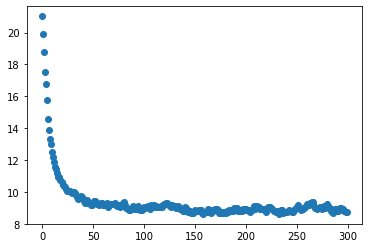

In [369]:
# The plotting

fitness_scores = algo[1]
plt.scatter(list(range(len(fitness_scores))), fitness_scores)